In [39]:
import pandas as pd
import torch
import networkx as nx
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

In [27]:
df = pd.read_csv("fraudTrain.csv")[:5000]

In [24]:
df

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,995,2019-01-01 12:38:38,6592243974328236,fraud_Beier and Sons,home,43.73,Philip,Hart,M,97405 Vazquez Plains,...,32.3374,-86.2715,214703,"Chemist, analytical",1994-10-07,c5f6d4b1ac5f1caba326608f0cf293fa,1325421518,32.744104,-87.025559,0
996,996,2019-01-01 12:39:18,4653879239169997,fraud_Pouros-Haag,shopping_pos,7.98,Monica,Tucker,F,302 Christina Islands,...,37.0581,-86.1938,6841,"Therapist, sports",1999-06-06,bc909cd211ddb4d3f6511abee1423324,1325421558,37.787593,-85.931895,0
997,997,2019-01-01 12:39:27,38588538868506,fraud_O'Keefe-Wisoky,food_dining,2.86,Jacqueline,Curry,F,3047 Jeff Place,...,30.1886,-103.2214,498,Lexicographer,1990-11-23,c882715837e35bc8a69be786678ea147,1325421567,29.273326,-104.007592,0
998,998,2019-01-01 12:39:46,5154903938030655,fraud_Mohr-Bayer,shopping_net,41.23,Felicia,Combs,F,825 Martinez Springs Apt. 625,...,37.7827,-80.3129,5216,Community development worker,1993-10-05,368a6a87fcbe04ab4f040e35e3b7d734,1325421586,36.890125,-80.382986,0


In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

def create_customer_merchant_multigraph(df):
    """
    Create a bipartite multigraph connecting customers (first+last) with merchants.
    Supports multiple transactions between the same customer-merchant pair.
    """
    G = nx.MultiGraph()
    
    for idx, row in df.iterrows():
        customer_id = f"{row['first']}_{row['last']}"
        
        if customer_id not in G:
            G.add_node(customer_id, type='customer', first_name=row['first'], last_name=row['last'])
        
        merchant_id = row['merchant']
        if merchant_id not in G:
            G.add_node(merchant_id, type='merchant')
        
        # Add edge with transaction data - multiple edges allowed between same nodes
        G.add_edge(customer_id, merchant_id, 
                   weight=float(row['amt']), 
                   original_index=idx,
                   transaction_data=row.to_dict())  # Store all row data if needed
    
    return G

def draw_fraud_multigraph(sub_G, figsize=(12, 8), node_size=100, font_size=8, 
                         fraud_edge_color='red', normal_edge_color='gray',
                         fraud_node_color='red', normal_node_color='lightblue',
                         alpha=0.7):
    """
    Draw a fraud multigraph with customized styling.
    
    Parameters:
    sub_G: networkx.MultiGraph - The multigraph to visualize
    figsize: tuple - Figure size
    node_size: int - Size of nodes (smaller than default)
    font_size: int - Size of node labels
    fraud_edge_color: str - Color for fraudulent edges
    normal_edge_color: str - Color for normal edges
    fraud_node_color: str - Color for fraudulent nodes
    normal_node_color: str - Color for normal nodes
    alpha: float - Transparency for edges
    """
    
    plt.figure(figsize=figsize)
    
    # Get node positions using spring layout
    pos = nx.spring_layout(sub_G, k=1, iterations=50)
    
    # Separate nodes by type and fraud status
    customer_nodes = [node for node, data in sub_G.nodes(data=True) if data.get('type') == 'customer']
    merchant_nodes = [node for node, data in sub_G.nodes(data=True) if data.get('type') == 'merchant']
    fraudulent_nodes = [node for node, data in sub_G.nodes(data=True) if data.get('is_fraudulent', False)]
    
    # Count transactions per node pair for edge width
    edge_weights = {}
    for u, v, key, data in sub_G.edges(data=True, keys=True):
        edge_key = (u, v)
        if edge_key not in edge_weights:
            edge_weights[edge_key] = 0
        edge_weights[edge_key] += 1
    
    # Separate edges by fraud status
    fraud_edges = []
    normal_edges = []
    
    for u, v, key, data in sub_G.edges(keys=True, data=True):
        if data.get('is_fraudulent', False):
            fraud_edges.append((u, v, key))
        else:
            normal_edges.append((u, v, key))
    
    # Draw normal edges first
    for u, v, key in normal_edges:
        edge_data = sub_G[u][v][key]
        num_transactions = edge_weights.get((u, v), 1)
        nx.draw_networkx_edges(sub_G, pos, edgelist=[(u, v)], 
                              edge_color=normal_edge_color, 
                              alpha=alpha*0.6, 
                              width=min(2.0, 0.5 + num_transactions * 0.3))
    
    # Draw fraud edges on top
    for u, v, key in fraud_edges:
        edge_data = sub_G[u][v][key]
        num_transactions = edge_weights.get((u, v), 1)
        nx.draw_networkx_edges(sub_G, pos, edgelist=[(u, v)], 
                              edge_color=fraud_edge_color, 
                              alpha=1.0, 
                              width=min(4.0, 1.0 + num_transactions * 0.5))
    
    # Draw merchant nodes
    nx.draw_networkx_nodes(sub_G, pos, nodelist=merchant_nodes, 
                          node_color=normal_node_color, node_size=node_size, alpha=alpha)
    
    # Draw customer nodes
    nx.draw_networkx_nodes(sub_G, pos, nodelist=customer_nodes, 
                          node_color='lightgreen', node_size=node_size, alpha=alpha)
    
    # Draw fraudulent nodes on top
    nx.draw_networkx_nodes(sub_G, pos, nodelist=fraudulent_nodes, 
                          node_color=fraud_node_color, node_size=node_size*1.5, alpha=1.0)
    
    # Draw labels
    nx.draw_networkx_labels(sub_G, pos, font_size=font_size, font_weight='bold')
    
    # Create legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor=fraud_node_color, label='Fraudulent Node'),
        Patch(facecolor='lightgreen', label='Customer Node'),
        Patch(facecolor=normal_node_color, label='Merchant Node'),
        Patch(facecolor=fraud_edge_color, label='Fraudulent Edge'),
        Patch(facecolor=normal_edge_color, label='Normal Edge')
    ]
    
    plt.legend(handles=legend_elements, loc='best')
    plt.title(f"Fraud MultiGraph\n{len(sub_G.nodes())} nodes, {sub_G.number_of_edges()} edges")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def draw_multigraph_simple(sub_G, node_size=80, fraud_color='red'):
    """
    Simple version for multigraph visualization.
    """
    plt.figure(figsize=(10, 6))
    pos = nx.spring_layout(sub_G)
    
    # For multigraph, we need to handle multiple edges
    # Draw edges with different styles based on fraud status
    normal_edges = []
    fraud_edges = []
    
    for u, v, key, data in sub_G.edges(keys=True, data=True):
        if data.get('is_fraudulent', False):
            fraud_edges.append((u, v))
        else:
            normal_edges.append((u, v))
    
    # Draw normal edges
    nx.draw_networkx_edges(sub_G, pos, edgelist=normal_edges, 
                          edge_color='gray', alpha=0.6, width=1.0)
    
    # Draw fraud edges
    nx.draw_networkx_edges(sub_G, pos, edgelist=fraud_edges, 
                          edge_color=fraud_color, alpha=1.0, width=2.5)
    
    # Color nodes
    node_colors = []
    for node, data in sub_G.nodes(data=True):
        if data.get('is_fraudulent', False):
            node_colors.append(fraud_color)
        elif data.get('type') == 'customer':
            node_colors.append('lightblue')
        else:
            node_colors.append('lightgreen')
    
    nx.draw_networkx_nodes(sub_G, pos, node_size=node_size, node_color=node_colors, alpha=0.8)
    nx.draw_networkx_labels(sub_G, pos, font_size=6)
    
    plt.title("Fraud Detection MultiGraph")
    plt.axis('off')
    plt.show()

def print_multigraph_stats(sub_G):
    """
    Print statistics about the fraud multigraph.
    """
    print("=" * 50)
    print("FRAUD MULTIGRAPH STATISTICS")
    print("=" * 50)
    print(f"Total nodes: {len(sub_G.nodes())}")
    print(f"Total edges: {sub_G.number_of_edges()}")
    
    # Count unique node pairs
    unique_edges = set()
    for u, v in sub_G.edges():
        unique_edges.add(tuple(sorted([u, v])))
    
    print(f"Unique customer-merchant pairs: {len(unique_edges)}")
    print(f"Average transactions per pair: {sub_G.number_of_edges() / len(unique_edges):.2f}")
    
    # Node types
    customer_nodes = [node for node, data in sub_G.nodes(data=True) if data.get('type') == 'customer']
    merchant_nodes = [node for node, data in sub_G.nodes(data=True) if data.get('type') == 'merchant']
    fraudulent_nodes = [node for node, data in sub_G.nodes(data=True) if data.get('is_fraudulent', False)]
    
    print(f"Customer nodes: {len(customer_nodes)}")
    print(f"Merchant nodes: {len(merchant_nodes)}")
    print(f"Fraudulent nodes: {len(fraudulent_nodes)}")
    
    # Edge fraud statistics
    fraud_edges = 0
    total_amount = 0
    fraud_amount = 0
    
    for u, v, key, data in sub_G.edges(keys=True, data=True):
        amount = data.get('weight', 0)
        total_amount += amount
        if data.get('is_fraudulent', False):
            fraud_edges += 1
            fraud_amount += amount
    
    print(f"Fraudulent edges: {fraud_edges}")
    print(f"Total transaction amount: ${total_amount:.2f}")
    print(f"Fraudulent amount: ${fraud_amount:.2f}")
    print(f"Fraud percentage by value: {(fraud_amount/total_amount*100):.2f}%")



    """
    Return individual connected components from the fraud subgraph.
    Useful for analyzing separate fraud patterns.
    """
    fraud_subgraph = isolate_fraud_subgraphs(G, fraudulent_indices, walk_length, reset_prob, num_walks)
    
    # Get connected components
    components = [fraud_subgraph.subgraph(c).copy() for c in nx.connected_components(fraud_subgraph)]
    
    # Sort by size (largest first)
    components.sort(key=lambda x: len(x.nodes()), reverse=True)
    
    return components

def isolate_fraud_subgraphs_advanced(G, fraudulent_indices, walk_length=1000, reset_prob=0.15, 
                                   num_walks=5, max_subgraph_size=100):
    """
    Advanced version with size control and better fraud focus for MultiGraph.
    """
    
    # Create mapping from original_index to edge
    index_to_edge = {}
    for u, v, key, data in G.edges(keys=True, data=True):
        if 'original_index' in data:
            index_to_edge[data['original_index']] = (u, v, key)
    
    # Get fraudulent nodes and mark them
    fraudulent_edges = set()
    fraudulent_nodes = set()
    
    for idx in fraudulent_indices:
        if idx in index_to_edge:
            u, v, key = index_to_edge[idx]
            fraudulent_edges.add((u, v, key))
            fraudulent_nodes.add(u)
            fraudulent_nodes.add(v)
    
    if not fraudulent_nodes:
        print("No fraudulent nodes found in the graph")
        return nx.MultiGraph()
    
    fraud_node_list = list(fraudulent_nodes)
    visited_nodes = set(fraudulent_nodes)
    visited_edges = set(fraudulent_edges)
    
    # Perform random walks
    for walk_num in range(num_walks):
        current_node = fraud_node_list[walk_num % len(fraud_node_list)]
        
        for step in range(walk_length):
            if len(visited_nodes) >= max_subgraph_size:
                break
                
            current_reset_prob = reset_prob
            if current_node not in fraudulent_nodes:
                current_reset_prob *= 2
                
            if np.random.random() < current_reset_prob:
                current_node = fraud_node_list[(walk_num + step) % len(fraud_node_list)]
            else:
                neighbors = list(G.neighbors(current_node))
                if neighbors:
                    next_node = np.random.choice(neighbors)
                    
                    # For MultiGraph, we need to track specific edges
                    edge_keys = list(G[current_node][next_node].keys())
                    if edge_keys:
                        key = np.random.choice(edge_keys)
                        edge_data = G[current_node][next_node][key]
                        
                        visited_edges.add((current_node, next_node, key))
                        visited_nodes.add(next_node)
                        current_node = next_node
    
    # Create subgraph - extract nodes and edges
    subgraph = nx.MultiGraph()
    
    # Add visited nodes with their attributes
    for node in visited_nodes:
        subgraph.add_node(node, **G.nodes[node])
    
    # Add visited edges with their attributes
    for u, v, key in visited_edges:
        if u in subgraph and v in subgraph:
            edge_data = G[u][v][key].copy()
            subgraph.add_edge(u, v, key=key, **edge_data)
    
    # Add fraud labels to nodes
    for node in subgraph.nodes():
        subgraph.nodes[node]['is_fraudulent'] = (node in fraudulent_nodes)
    
    # Add fraud labels to edges
    for u, v, key, data in subgraph.edges(keys=True, data=True):
        original_idx = data.get('original_index', None)
        subgraph[u][v][key]['is_fraudulent'] = (original_idx in fraudulent_indices)
    
    return subgraph


In [91]:
G = create_customer_merchant_multigraph(df)

In [93]:
fradulent = df["is_fraud"].to_numpy()
print(fradulent.sum())

22


In [94]:
fraud_id = []
for i in range(len(fradulent)):
  inst = fradulent[i]
  if inst == 1:
    fraud_id.append(i)

In [96]:
sub_G = isolate_fraud_subgraphs_advanced(G, fraud_id[:3], walk_length=30, reset_prob=0.15, num_walks=3)

In [103]:
# Alternative simpler version
def draw_fraud_simple(sub_G, node_size=80, fraud_color='red'):
    """
    Simple version with minimal styling.
    """
    plt.figure(figsize=(10, 6))
    pos = nx.spring_layout(sub_G)
    
    # Color edges based on fraud status
    edge_colors = []
    for u, v, data in sub_G.edges(data=True):
        if data.get('is_fraudulent', False):
            edge_colors.append(fraud_color)
        else:
            edge_colors.append('gray')
    
    # Color nodes based on fraud status
    node_colors = []
    for node, data in sub_G.nodes(data=True):
        if data.get('is_fraudulent', False):
            node_colors.append(fraud_color)
        elif data.get('type') == 'customer':
            node_colors.append('lightblue')
        else:
            node_colors.append('lightgreen')
    
    nx.draw(sub_G, pos, 
            node_size=node_size, 
            node_color=node_colors,
            edge_color=edge_colors,
            font_size=6,
            width=1,
            alpha=0.8)
    
    plt.title("Fraud Detection Subgraph")
    plt.axis('off')
    plt.show()

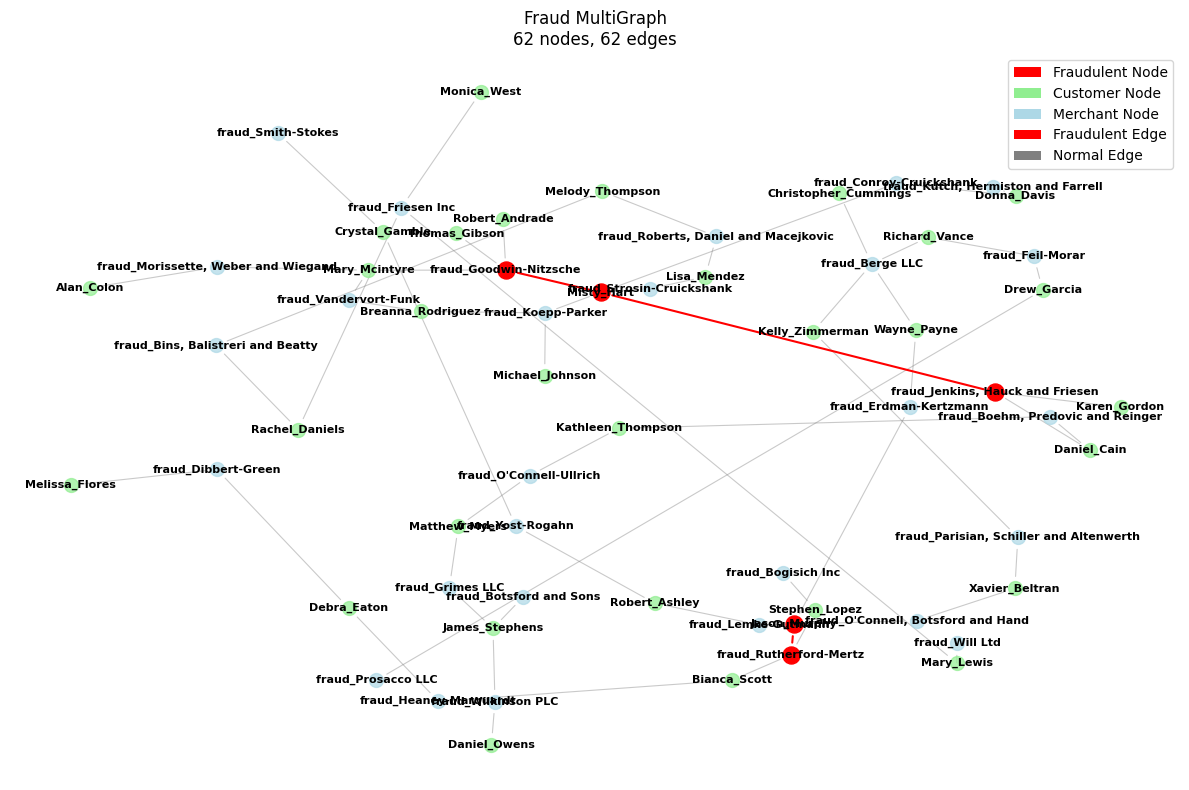

In [107]:
draw_fraud_multigraph(sub_G)

In [112]:
fraudulent_indices = fraud_id[:3]
print_multigraph_stats(sub_G)

FRAUD MULTIGRAPH STATISTICS
Total nodes: 62
Total edges: 62
Unique customer-merchant pairs: 62
Average transactions per pair: 1.00
Customer nodes: 32
Merchant nodes: 30
Fraudulent nodes: 5
Fraudulent edges: 3
Total transaction amount: $5860.31
Fraudulent amount: $568.89
Fraud percentage by value: 9.71%


NameError: name 'walk_length' is not defined